<a href="https://colab.research.google.com/github/Jeon-doun/Electronic_Car_Price_Prediction/blob/main/%EC%A0%84%EA%B8%B0%EC%B0%A8_%EA%B0%80%EA%B2%A9_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 라이브러리 호출

In [1]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00


In [89]:
# ! pip uninstall scikit-learn

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/scikit_learn-1.5.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/sklearn/*
Proceed (Y/n)? Y
  Successfully uninstalled scikit-learn-1.5.2


In [90]:
# ! pip install scikit-learn==1.5.2

  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [52]:
# pip install wandb

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from scipy import stats
import matplotlib.font_manager as fm
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# import tensorflow as tf
# import wandb
sns.set_theme()

In [16]:
#! sudo apt-get install -y fonts-nanum
#! sudo fc-cache -fv
#! rm ~/.cache/matplotlib -rf

In [2]:
plt.rc('font', family='NanumBarunGothic') # 폰트 설정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷

In [263]:
import matplotlib.font_manager as fm
import matplotlib

font_location = 'C:/Windows/Fonts/malgun.ttf' # 폰트 파일 이름, 디렉토리 주의
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정(필수)

# 현재 글꼴 확인
print(plt.rcParams['font.family'])

['Malgun Gothic']


### 1. 데이터 입수

In [10]:
train_df = pd.read_csv('https://raw.githubusercontent.com/Jeon-doun/Electronic_Car_Price_Prediction/refs/heads/main/train.csv')
train_df

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02
...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,NaN,AWD,3773,10,No,0,35.95
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40
7494,TRAIN_7494,P사,TayCT,Brand New,NaN,AWD,1363,2,No,0,120.00
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00


In [22]:
train_df_2 = train_df.drop(columns = 'ID')

In [12]:
test_df = pd.read_csv('https://raw.githubusercontent.com/Jeon-doun/Electronic_Car_Price_Prediction/refs/heads/main/test.csv')

### 2. 데이터 EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


- 배터리용량 결측치 존재

In [ ]:
train_df.isnull().sum() / len(train_df)

,0
ID,0.000000
제조사,0.000000
모델,0.000000
차량상태,0.000000
배터리용량,0.361611
구동방식,0.000000
주행거리(km),0.000000
보증기간(년),0.000000
사고이력,0.000000
연식(년),0.000000


- 수치형 변수 시각화
  - 배터리용량 80~90구간이 현저히 적음 (결측구간이 아닌지 의심)

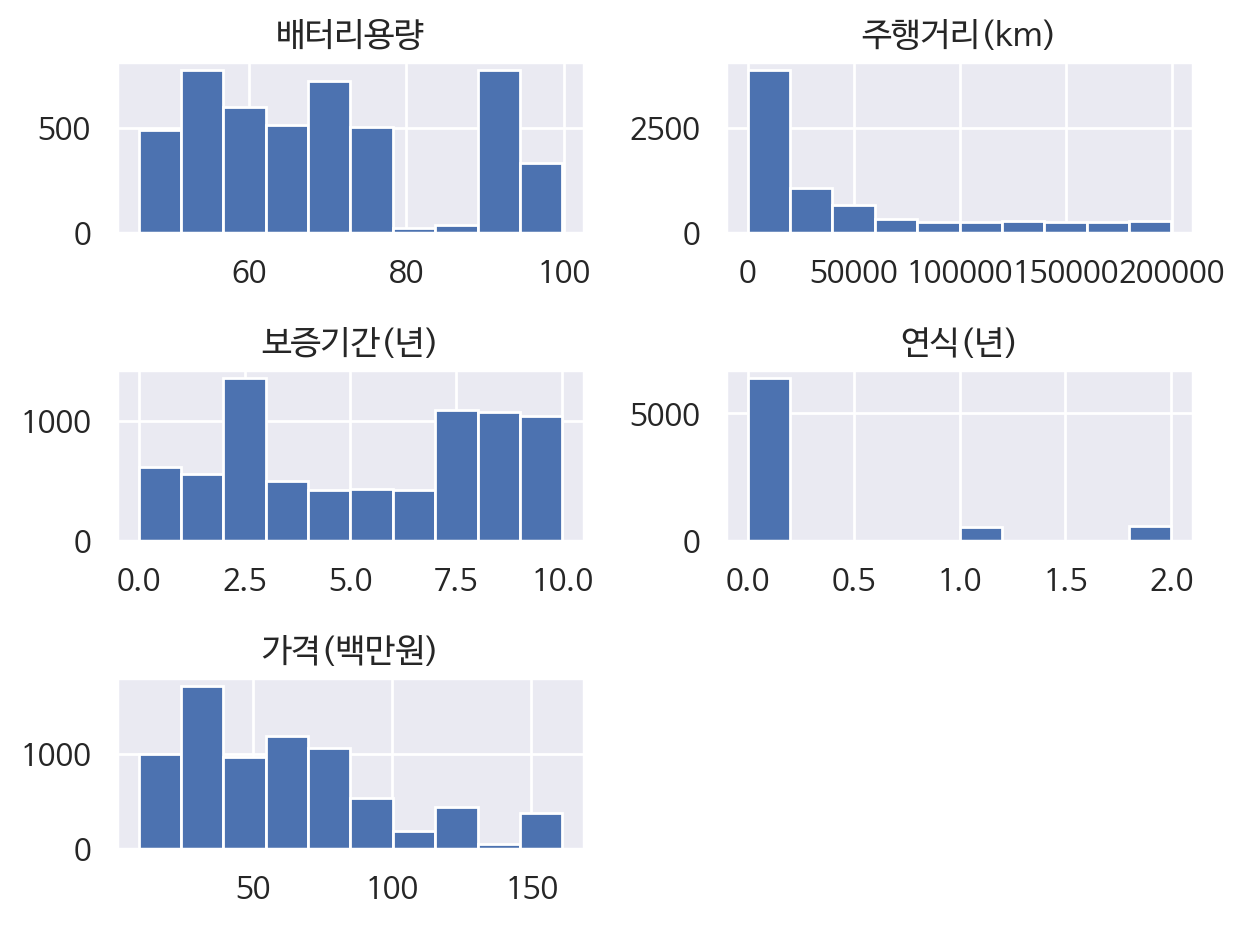

In [ ]:
train_df_2.hist()
plt.tight_layout()
plt.show()

In [8]:
train_df.제조사.value_counts()

,count
제조사,
H사,1237
B사,1169
K사,1164
A사,1142
T사,1109
P사,1071
V사,605


제조사별 가격 차이가 확인됨 -> 제조사별로 가격 예측을 해보자

In [8]:
train_df.groupby('제조사')['가격(백만원)'].mean()

,가격(백만원)
제조사,
A사,75.128354
B사,55.212344
H사,31.312991
K사,30.779029
P사,131.990934
T사,70.153724
V사,38.411702


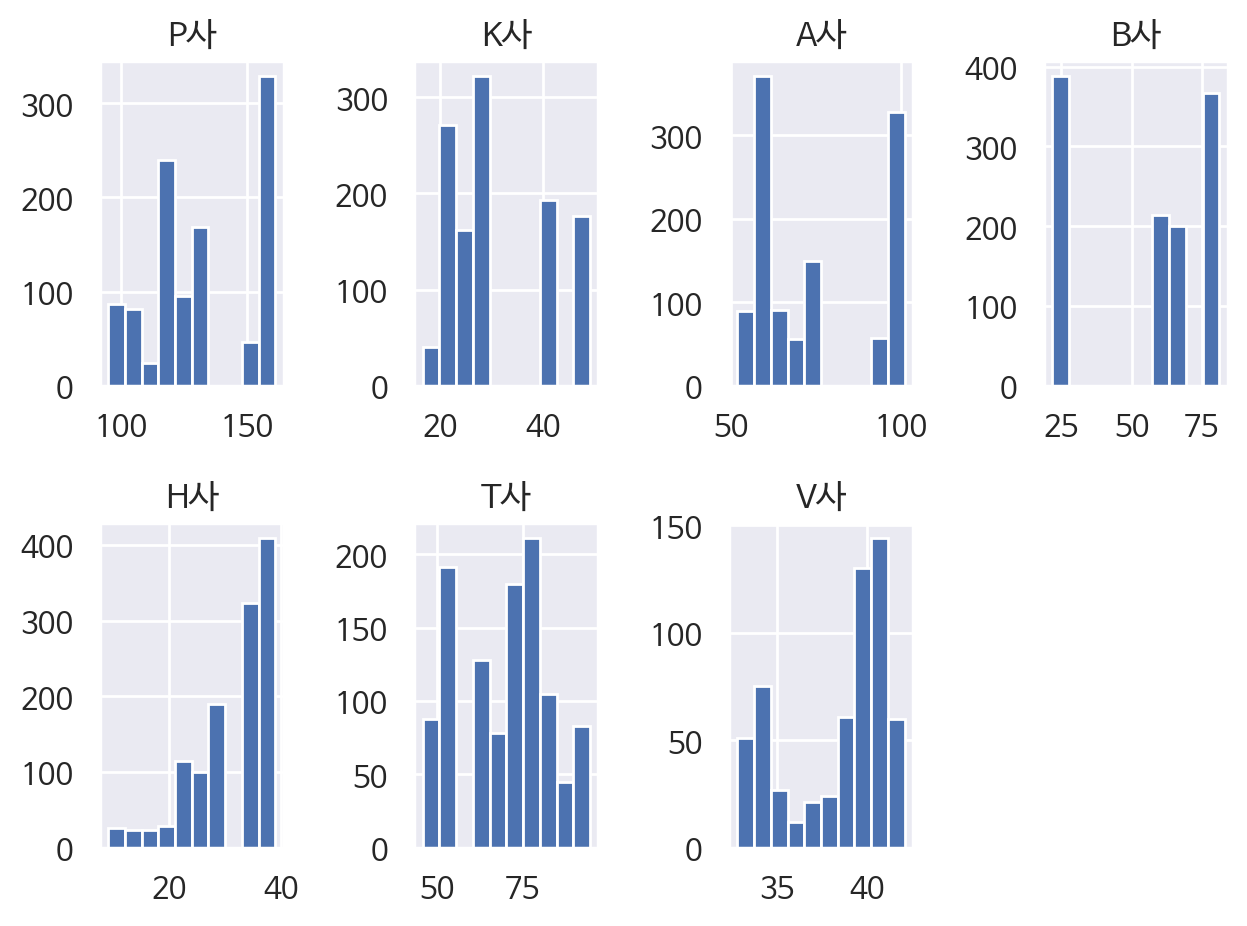

In [7]:
for i, firm in enumerate(train_df.제조사.unique()):
  plt.subplot(2, 4, i+1)
  target = train_df.loc[train_df.제조사 == firm]
  target['가격(백만원)'].hist()
  plt.title(firm)
plt.tight_layout()
plt.show()

- 결측치 검토
  - 결측치가 특정 범주에 국한되지는 않음
  - 보증기간은 상대적으로 길고 주행거리는 짧은 편

In [ ]:
train_df_2.describe(include = 'all')

,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
count,7497,7497,7497,4786.000000,7497,7497.000000,7497.000000,7497,7497.000000,7497.000000
unique,7,21,3,NaN,3,NaN,NaN,2,NaN,NaN
top,H사,ID4,Brand New,NaN,AWD,NaN,NaN,No,NaN,NaN
freq,1237,605,3380,NaN,5167,NaN,NaN,7154,NaN,NaN
mean,NaN,NaN,NaN,69.397187,NaN,44287.979458,4.960918,NaN,0.222489,62.331949
std,NaN,NaN,NaN,15.283635,NaN,55204.064386,3.155342,NaN,0.569232,36.646759
min,NaN,NaN,NaN,46.000000,NaN,3.000000,0.000000,NaN,0.000000,9.000000
25%,NaN,NaN,NaN,56.359000,NaN,5465.000000,2.000000,NaN,0.000000,34.390000
50%,NaN,NaN,NaN,68.125000,NaN,17331.000000,5.000000,NaN,0.000000,56.000000
75%,NaN,NaN,NaN,78.227000,NaN,61252.000000,8.000000,NaN,0.000000,80.050000


In [ ]:
train_df_2.loc[train_df_2.isnull().any(axis = 1)].describe(include = 'all')

,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
count,2711,2711,2711,0.0,2711,2711.000000,2711.000000,2711,2711.000000,2711.000000
unique,7,21,3,NaN,3,NaN,NaN,2,NaN,NaN
top,A사,EV6,Brand New,NaN,AWD,NaN,NaN,No,NaN,NaN
freq,483,300,2308,NaN,1884,NaN,NaN,2591,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,12408.756179,6.752859,NaN,0.082995,66.339107
std,NaN,NaN,NaN,NaN,NaN,25896.636625,2.860110,NaN,0.353332,35.019052
min,NaN,NaN,NaN,NaN,NaN,3.000000,0.000000,NaN,0.000000,9.770000
25%,NaN,NaN,NaN,NaN,NaN,2837.500000,5.000000,NaN,0.000000,38.940000
50%,NaN,NaN,NaN,NaN,NaN,5770.000000,8.000000,NaN,0.000000,59.960000
75%,NaN,NaN,NaN,NaN,NaN,8820.000000,9.000000,NaN,0.000000,93.810000


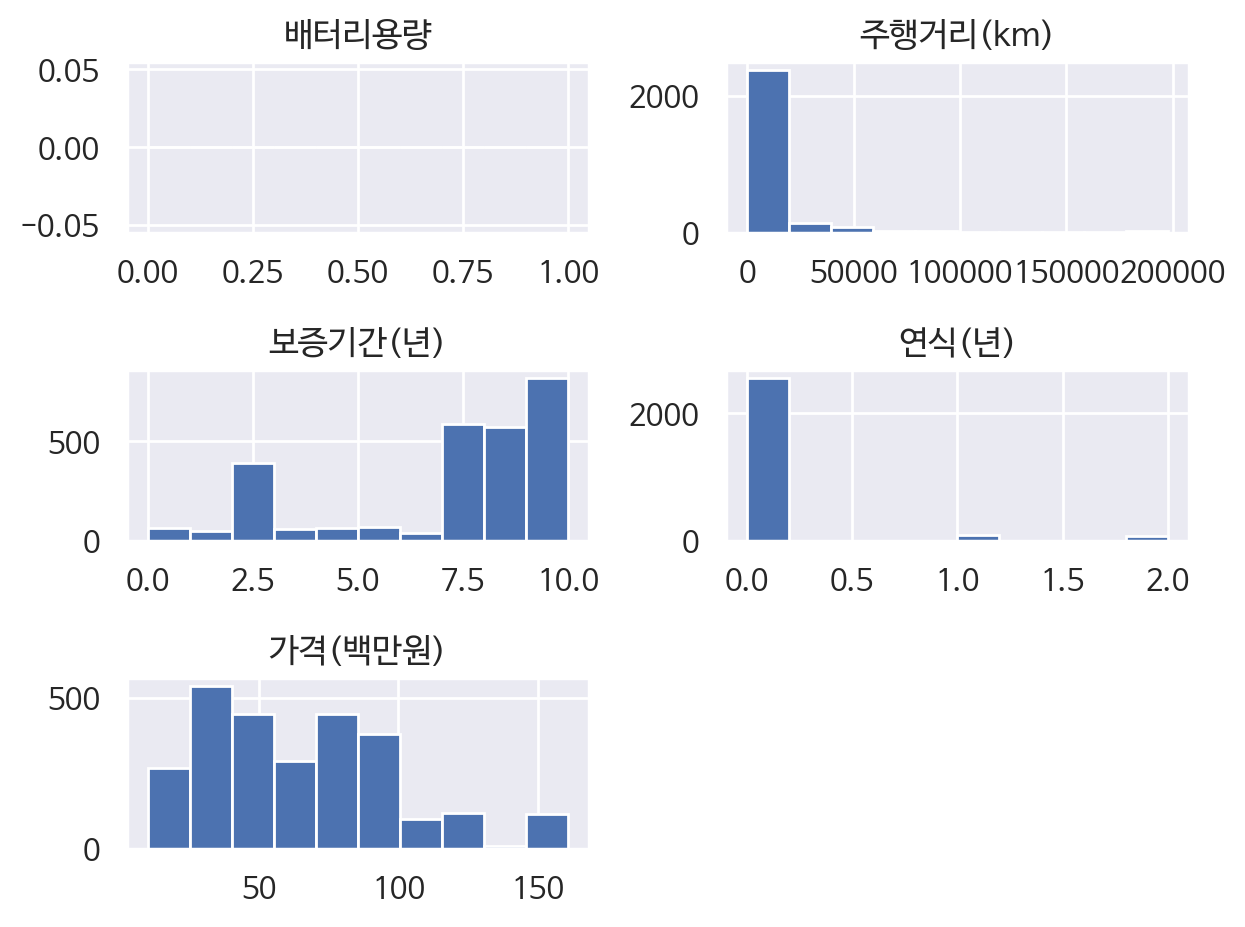

In [ ]:
train_df_2.loc[train_df_2.isnull().any(axis = 1)].hist()
plt.tight_layout()
plt.show()

- 가격 변수에 이상치 확인, 전처리 필요

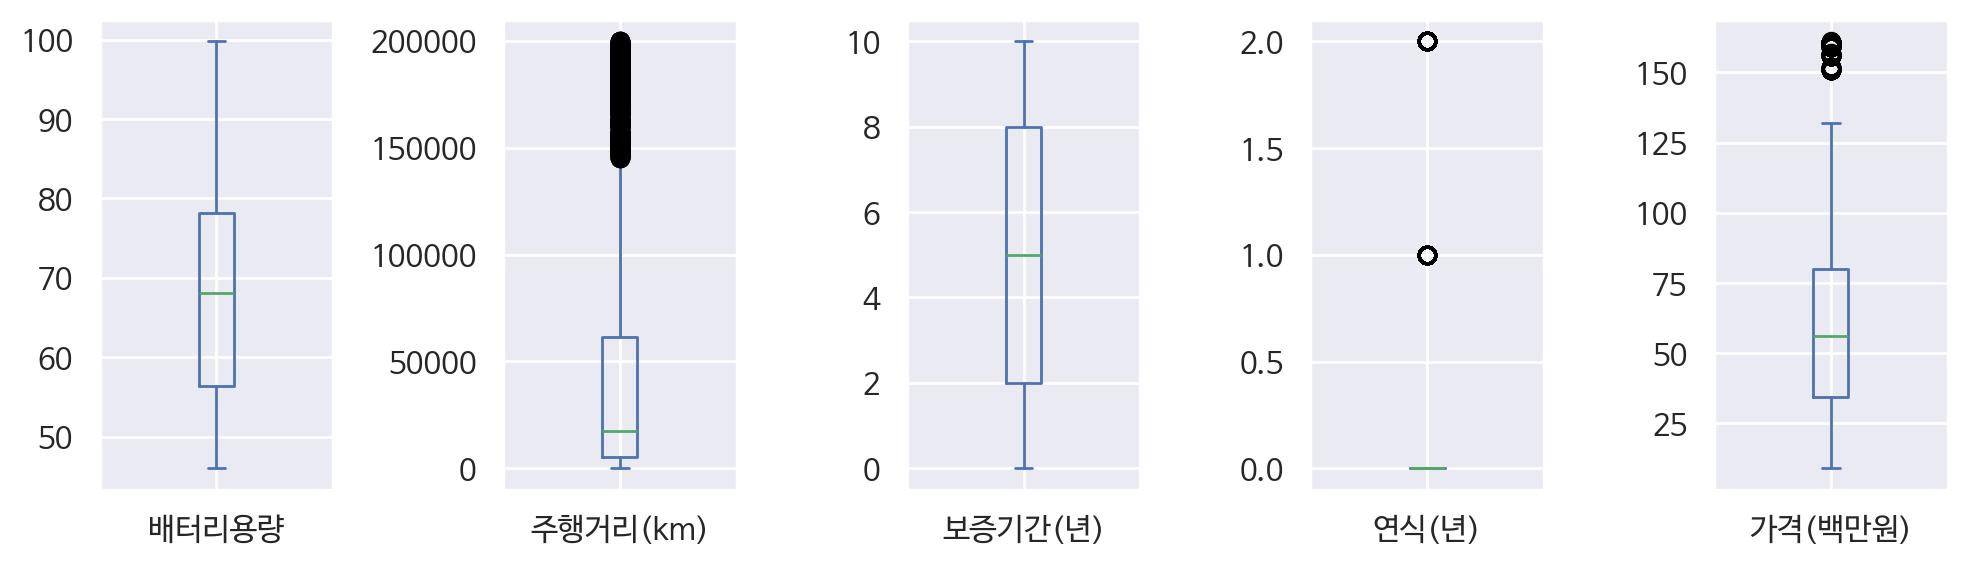

In [ ]:
train_df.plot(kind = 'box', subplots = True, figsize = (10, 3))
plt.tight_layout()
plt.show()

- 상관관계 분석
  - 배터리용량과 주행거리는 음, 보증기간은 양의 상관관계
  - 배터리용량을 주행거리와 보증기간에 대해 회귀분석하여 결측치 대체 진행
  - 변수 간 다중공선성 의심 => 회귀 모형 대신 트리 기반 모형 검토

In [ ]:
train_df_2.corr(numeric_only = True)

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.576538,0.558242,-0.021845,0.431668
주행거리(km),-0.576538,1.000000,-0.664071,-0.089586,-0.035488
보증기간(년),0.558242,-0.664071,1.000000,0.035294,-0.349962
연식(년),-0.021845,-0.089586,0.035294,1.000000,-0.058455
가격(백만원),0.431668,-0.035488,-0.349962,-0.058455,1.000000


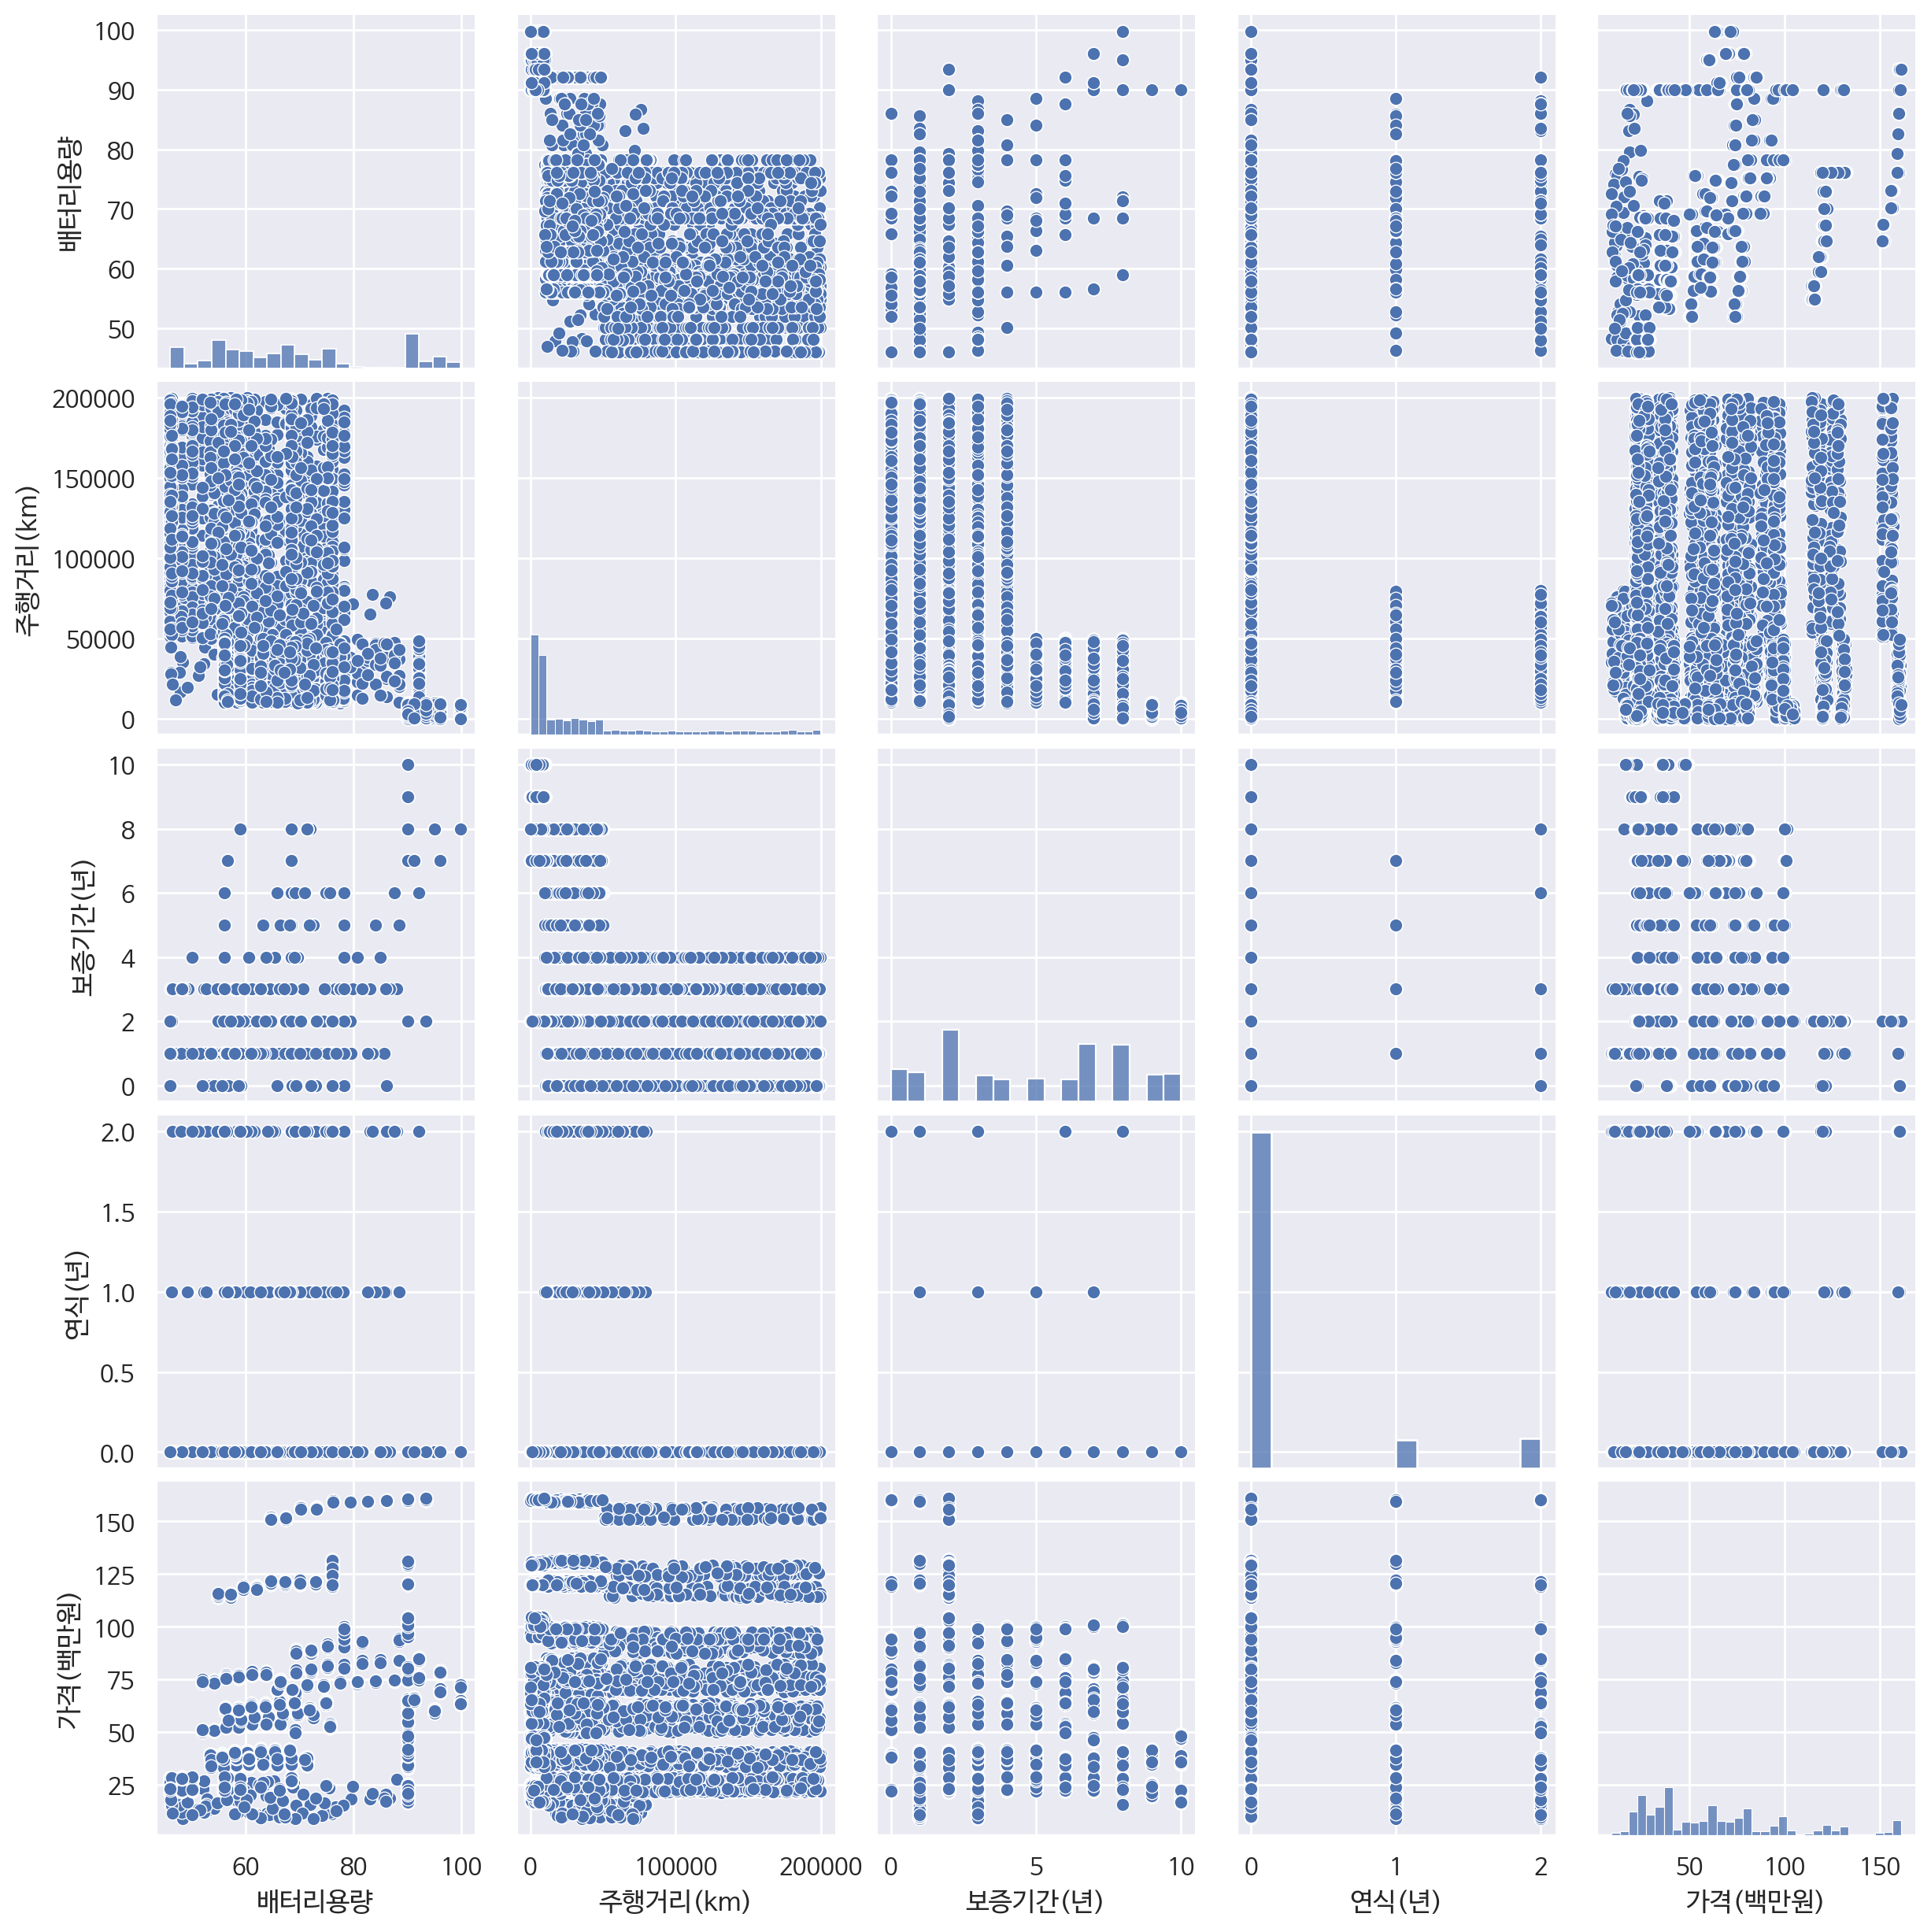

In [ ]:
sns.pairplot(train_df.select_dtypes(exclude = 'object'))
plt.show()

- 범주형 변수 시각화
  - 사고이력 분포 불균형 심함

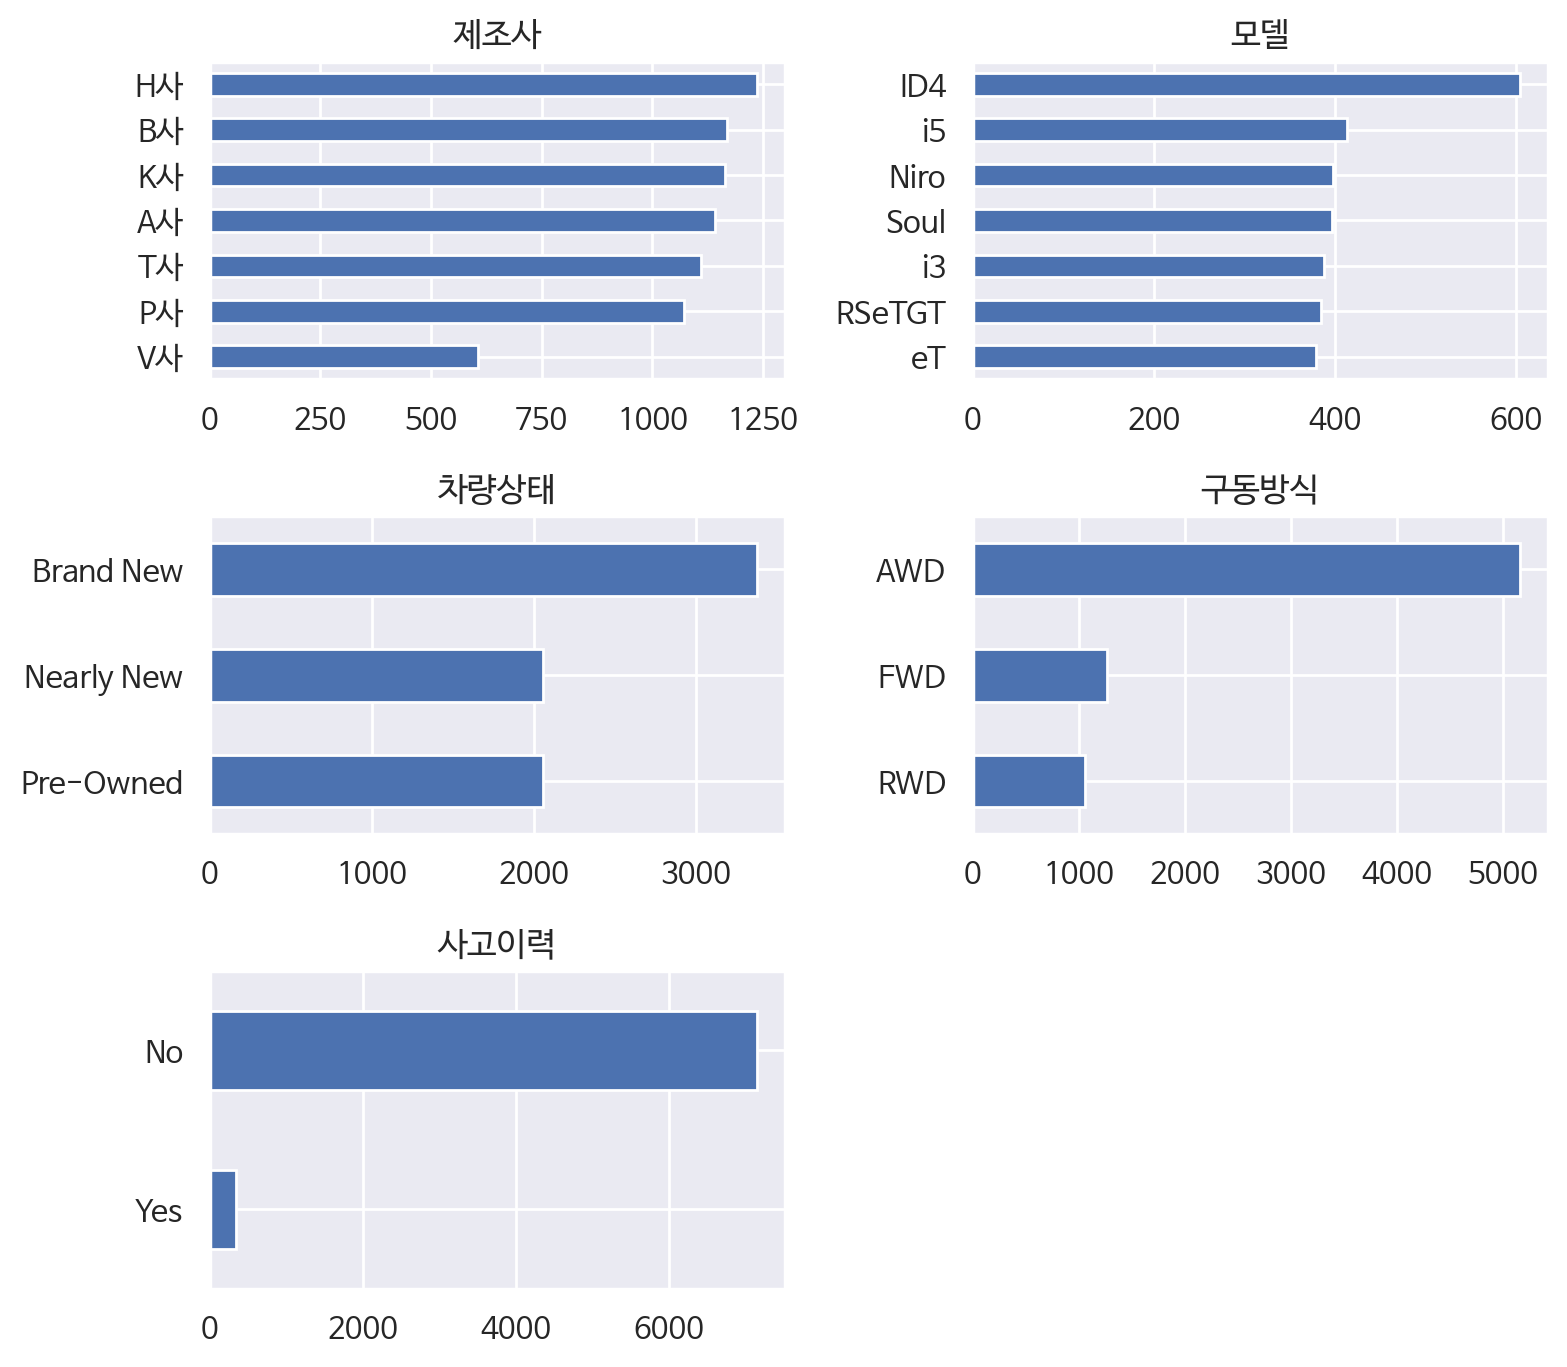

In [ ]:
plt.figure(figsize = (8, 7))

for i, col in enumerate(train_df_2.select_dtypes(include = 'object').columns):
  plt.subplot(3, 2, i+1)
  train_df_2[col].value_counts().sort_values().tail(7).plot(kind = 'barh', title = col)
  plt.ylabel('')

plt.tight_layout()
plt.show()

### 3. 전처리

- 가격 스케일링 - log 변환을 최적의 변환으로 적용


In [9]:
y_boxcox, lambda_optimal = stats.boxcox(train_df['주행거리(km)'])

In [11]:
lambda_optimal

0.11853368931536742

[]

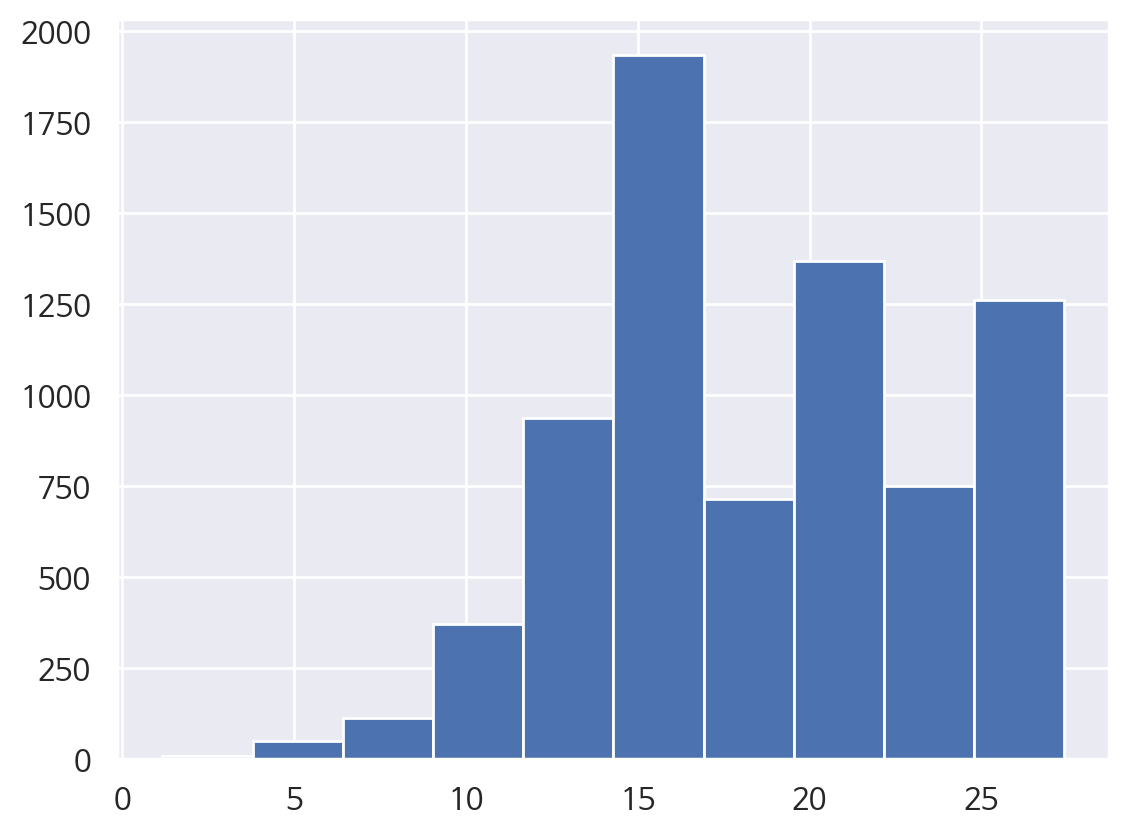

In [10]:
plt.hist(y_boxcox)
plt.plot()

- 결측치 처리

In [44]:
lr_model = LinearRegression()
target_df = train_df.dropna()

# 주행거리와 보증기간을 이용하여 배터리용량 예측
lr_model.fit(target_df.loc[:,['주행거리(km)','보증기간(년)']], target_df['배터리용량'])

LinearRegression()

In [45]:
lr_model.score(target_df.loc[:,['주행거리(km)','보증기간(년)']], target_df['배터리용량'])

0.38924874189722714

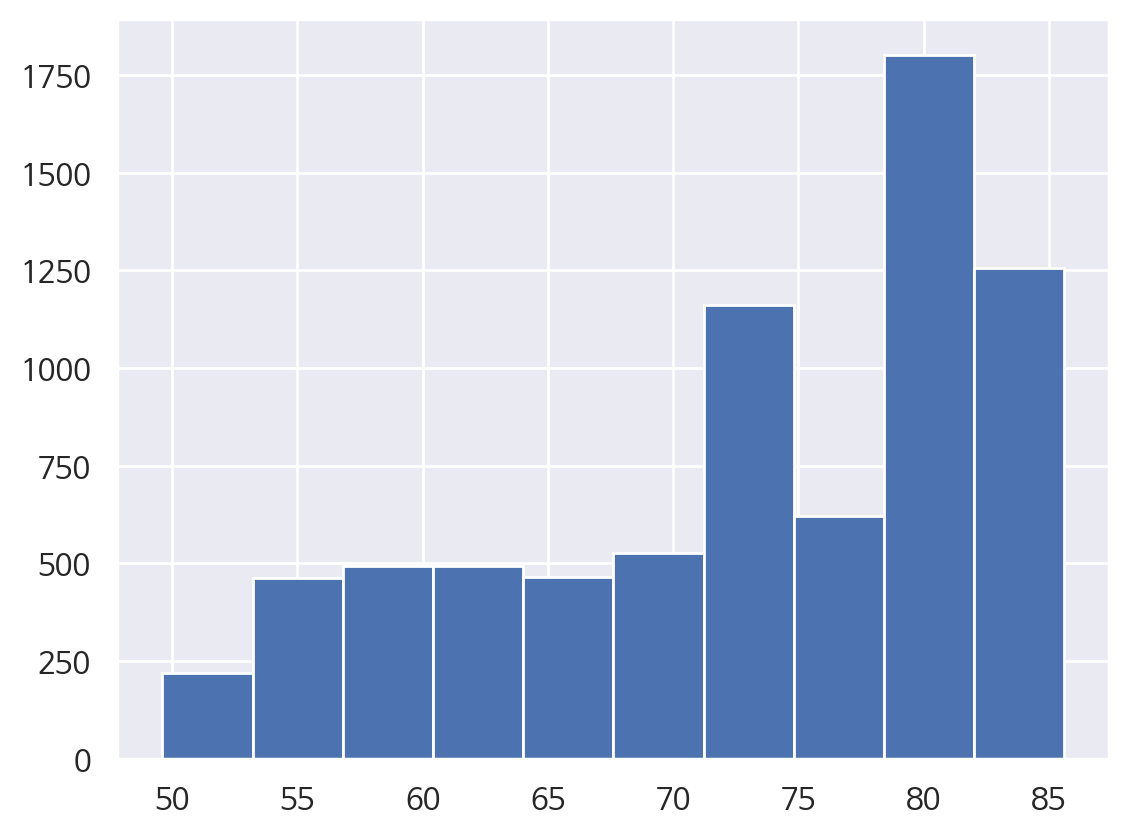

In [ ]:
plt.hist(lr_model.predict(train_df_2.loc[:,['주행거리(km)','보증기간(년)']]))
plt.show()

- 가격 이상치 처리

In [ ]:
train_df_2.loc[train_df_2['가격(백만원)'] > 140, '가격(백만원)'].sort_values(ascending = False)

,가격(백만원)
4387,161.09
7388,161.01
6617,160.99
1769,160.99
2638,160.96
...,...
1187,151.00
31,151.00
3692,151.00
292,151.00


<Axes: >

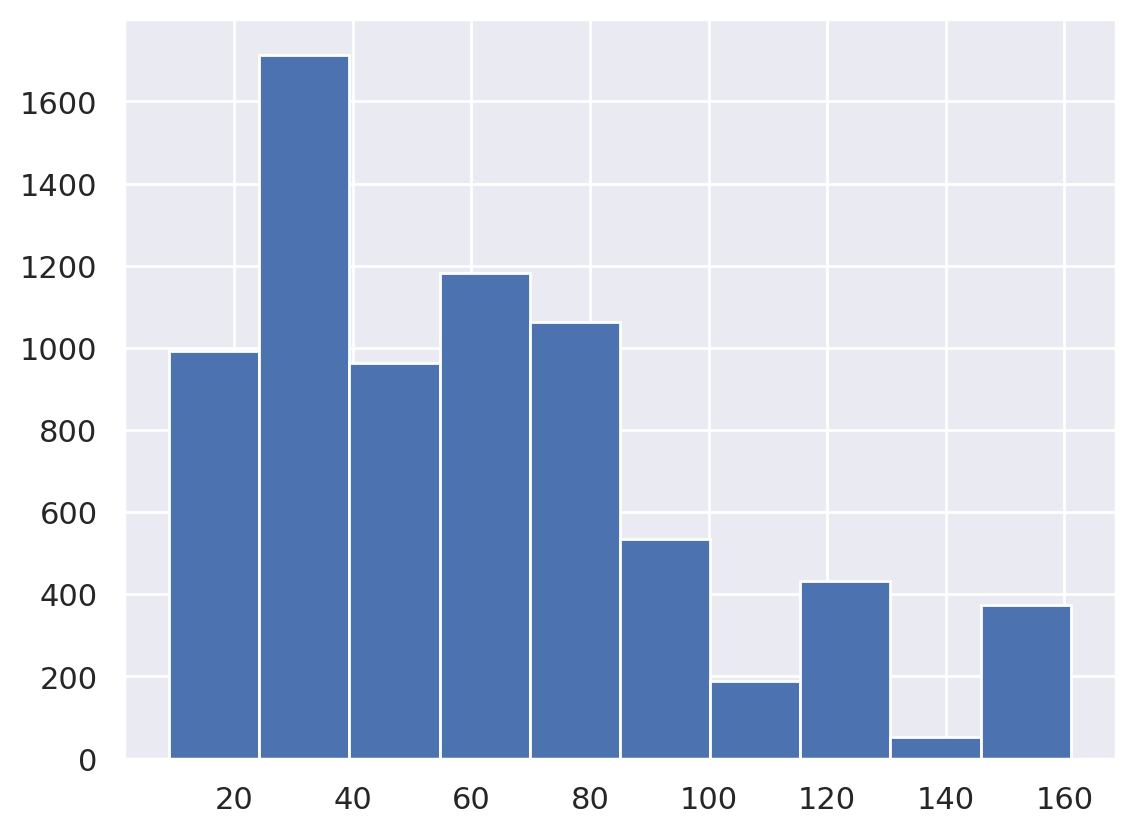

In [ ]:
train_df_2['가격(백만원)'].hist()

In [ ]:
train_df_2['가격(백만원)'].clip(train_df_2['가격(백만원)'].min(), 150)

,가격(백만원)
0,150.00
1,28.01
2,66.27
3,99.16
4,62.02
...,...
7492,35.95
7493,23.40
7494,120.00
7495,24.00


-  주행거리 이상치 처리
  - 주행거리(km) 이상치 처리를 위해 구간화

In [ ]:
pd.qcut(train_df_2['주행거리(km)'], 8).value_counts()

,count
주행거리(km),
"(2.999, 2695.0]",939
"(5465.0, 8244.0]",937
"(8244.0, 17331.0]",937
"(17331.0, 34749.0]",937
"(34749.0, 61252.0]",937
"(61252.0, 129637.0]",937
"(129637.0, 199827.0]",937
"(2695.0, 5465.0]",936


- 보증기간 이상치 처리

In [ ]:
pd.qcut(train_df_2['보증기간(년)'], 5).value_counts().sort_index()

,count
보증기간(년),
"(-0.001, 2.0]",2528
"(2.0, 3.0]",494
"(3.0, 7.0]",2365
"(7.0, 8.0]",1073
"(8.0, 10.0]",1037


In [ ]:
train_df_2['보증기간(년)'].value_counts()

,count
보증기간(년),
2,1358
7,1093
8,1073
0,618
1,552
10,522
9,515
3,494
5,428


- 차량크기 파생변수 생성

In [24]:
차량크기 = {'ID4':'준중형','i5':'준대형','Niro':'소형','Soul':'소형',
        'i3':'중형','RseTGT':'대형','eT':'준대형','ION6':'중형',
        'Q4eT':'준중형','EV6':'준중형','iX':'준대형','ION5':'준중형',
        'IONIQ':'준중형'}

- 모델별 비중 동일하게 sampling

### 전처리 함수 생성

In [27]:
주행거리_interval = pd.qcut(train_df_2['주행거리(km)'], 10).value_counts().sort_index().index

In [30]:
주행거리_bocox, 주행거리_lambda_optimal = stats.boxcox(train_df['주행거리(km)'])

In [32]:
def preprocessing_train(df_first, null_pred_model, 주행거리_interval):

  df = df_first.copy()

  # 결측치 처리
  df['배터리용량'] = df['배터리용량'].fillna(pd.Series(null_pred_model.predict(df.loc[:,['주행거리(km)','보증기간(년)']])))

  # 가격 이상치 처리 - 오히려 성능 악화
  # df.loc[df['가격(백만원)'] > 150, '가격(백만원)'] = 150

  # 주행거리
  df[f'주행거리:{주행거리_interval[0].right}이하'] = df['주행거리(km)'].map(lambda x : 1 if x <= 주행거리_interval[0].right else 0)

  for i in range(len(주행거리_interval) - 1):
    df[f'주행거리:{주행거리_interval[i+1].right}이하'] = df['주행거리(km)'].map(lambda x : 1 if x > 주행거리_interval[i+1].left and x <= 주행거리_interval[i+1].right else 0)

  df[f'주행거리:{주행거리_interval[-1].right}초과'] = df['주행거리(km)'].map(lambda x : 1 if x > 주행거리_interval[-1].left else 0)

  # 차량크기 파생변수

  df['차량크기'] = df['모델'].map(lambda x : 차량크기[x] if x in 차량크기.keys() else '불명')

  # 가격 로그변환
  # df['가격(백만원)'] = np.log(df['가격(백만원)'])

  # 주행거리 변수 제거

  df = df.drop(columns = '주행거리(km)')

  return df

In [34]:
def preprocessing_test(df_first, null_pred_model, 주행거리_interval):

  df = df_first.copy()

  # 결측치 처리
  df['배터리용량'] = df['배터리용량'].fillna(pd.Series(null_pred_model.predict(df.loc[:,['주행거리(km)','보증기간(년)']])))

  # 가격 이상치 처리 - 오히려 성능 악화
  # df.loc[df['가격(백만원)'] > 150, '가격(백만원)'] = 150

  # 주행거리
  df[f'주행거리:{주행거리_interval[0].right}이하'] = df['주행거리(km)'].map(lambda x : 1 if x <= 주행거리_interval[0].right else 0)

  for i in range(len(주행거리_interval) - 1):
    df[f'주행거리:{주행거리_interval[i+1].right}이하'] = df['주행거리(km)'].map(lambda x : 1 if x > 주행거리_interval[i+1].left and x <= 주행거리_interval[i+1].right else 0)

  df[f'주행거리:{주행거리_interval[-1].right}초과'] = df['주행거리(km)'].map(lambda x : 1 if x > 주행거리_interval[-1].left else 0)

  # 차량크기 파생변수

  df['차량크기'] = df['모델'].map(lambda x : 차량크기[x] if x in 차량크기.keys() else '불명')

  # 가격 로그변환
  # df['가격(백만원)'] = np.log(df['가격(백만원)'])

  # 주행거리 변수 제거

  df = df.drop(columns = '주행거리(km)')

  return df

In [ ]:
def preprocessing_boxcox_train(df_first, null_pred_model, 주행거리_interval):

  df = df_first.copy()

  # 결측치 처리
  df['배터리용량'] = df['배터리용량'].fillna(pd.Series(null_pred_model.predict(df.loc[:,['주행거리(km)','보증기간(년)']])))

  # 주행거리
  df['주행거리(km)'] = stats.boxcox(df['주행거리(km)'], lmbda= 주행거리_lambda_optimal)

  # 차량크기 파생변수

  df['차량크기'] = df['모델'].map(lambda x : 차량크기[x] if x in 차량크기.keys() else '불명')

  # 가격 로그변환
  df['가격(백만원)'] = np.log(df['가격(백만원)'])

  return df

In [ ]:
def preprocessing_boxcox_test(df_first, null_pred_model, 주행거리_interval):

  df = df_first.copy()

  # 결측치 처리
  df['배터리용량'] = df['배터리용량'].fillna(pd.Series(null_pred_model.predict(df.loc[:,['주행거리(km)','보증기간(년)']])))

  # 주행거리
  df['주행거리(km)'] = stats.boxcox(df['주행거리(km)'], lmbda= 주행거리_lambda_optimal)

  # 차량크기 파생변수

  df['차량크기'] = df['모델'].map(lambda x : 차량크기[x] if x in 차량크기.keys() else '불명')

  # 가격 로그변환
  # df['가격(백만원)'] = np.log(df['가격(백만원)'])

  return df

In [ ]:
def preprocessing_less(df_first, null_pred_model, 주행거리_interval):

  df = df_first.copy()

  # 결측치 처리
  df['배터리용량'] = df['배터리용량'].fillna(pd.Series(null_pred_model.predict(df.loc[:,['주행거리(km)','보증기간(년)']])))

  # 가격 이상치 처리 - 오히려 성능 악화
  # df.loc[df['가격(백만원)'] > 150, '가격(백만원)'] = 150

  # 주행거리
  for i in range(len(주행거리_interval) - 1):
    df[f'주행거리:{주행거리_interval[i].right}이하'] = df['주행거리(km)'].map(lambda x : 1 if x <= 주행거리_interval[i].right else 0)

  df[f'주행거리:{주행거리_interval[-1].right}초과'] = df['주행거리(km)'].map(lambda x : 1 if x > 주행거리_interval[-1].left else 0)

  # 차량크기 파생변수

  df['차량크기'] = df['모델'].map(lambda x : 차량크기[x] if x in 차량크기.keys() else '불명')

  # 가격 로그변환
  df['가격(백만원)'] = np.log(df['가격(백만원)'])

  # 주행거리 변수 제거

  df = df.drop(columns = '주행거리(km)')

  return df

In [16]:
# 자료 변환 및 더미변수 생성

train_df_2 = train_df.drop(columns = 'ID')
train_df_3 = preprocessing_train(df_first = train_df_2, null_pred_model = lr_model, 주행거리_interval = 주행거리_interval)
train_df_4 = pd.get_dummies(train_df_3, prefix_sep = ':',  dtype = int).drop(columns = '사고이력:No')

In [20]:
train_df_2.select_dtypes(include = 'object').columns

Index(['제조사', '모델', '차량상태', '구동방식', '사고이력'], dtype='object')

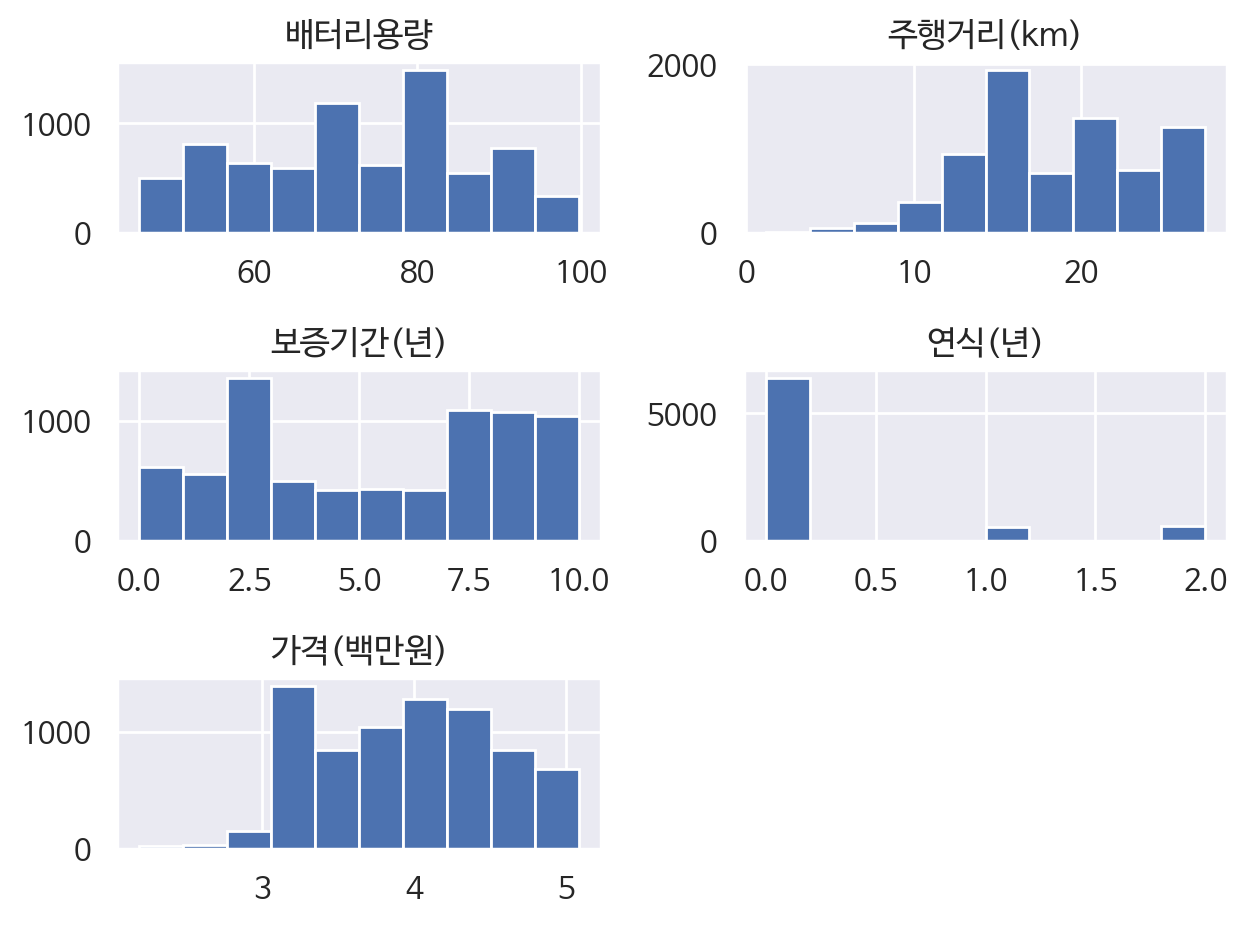

In [ ]:
train_df_3.hist()
plt.tight_layout()
plt.show()

### 4. 데이터 분리

In [36]:
X_train = train_df_4.drop(columns = '가격(백만원)')
y_train = train_df_4['가격(백만원)']

NameError: name 'train_df_4' is not defined

### 5. 머신러닝 모델링

- XGBoost

In [30]:
xgb_reg_model = XGBRegressor()

In [19]:
xgb_param_grid = {'n_estimators' : [100, 300, 500], 'learning_rate':[0.1, 0.05, 0.01]}
xgb_grid = GridSearchCV(estimator = xgb_reg_model, param_grid = xgb_param_grid, scoring = 'neg_mean_squared_error')

In [20]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_mean_squared_error')

In [ ]:
# 주행거리 8구간 + 보증기간 4구간 => -2.336423728143647
# 결측치 선형회귀 모델링, 주행거리 누적 10구간, 주행거리 변수 미삭제, 차량크기 파생변수 => -2.065493716106013
# 주행거리 구간 x => -1.9830444656786956
# 결측치 xgboost 모델링, 주행거리 10구간 => -1.8964179200039795
# 결측치 선형회귀 모델링, 주행거리 10구간 => -1.8917466627572963
# 주행거리 5구간 => -1.8695255679477512
# 주행거리 8구간 => -1.852389252273587
# 결측치 xgboost 모델링, 주행거리 10구간, 차량크기 파생변수 => -1.8490530729821937
# 결측치 선형회귀 모델링, 가격 이상치 150 이하로 clip, 주행거리 6구간, 차량크기 파생변수 => -1.84863544012619
# 결측치 xgboost 모델링, 주행거리 8구간 => -1.8479643180041527
# 결측치 xgboost 모델링, 주행거리 10구간, 차량크기 파생변수 => -1.8411807167839078
# 결측치 선형회귀 모델링, 주행거리 누적 6구간, 차량크기 파생변수 => -1.8327796923728912
# 결측치 선형회귀 모델링, 주행거리 8구간, 차량크기 파생변수 => -1.814560454005957
# 결측치 선형회귀 모델링, 주행거리 4구간, 차량크기 파생변수 => -1.8118973885212473
# 결측치 선형회귀 모델링, 주행거리 6구간, 차량크기 파생변수 => -1.8051676581089815
# 결측치 선형회귀 모델링, 주행거리 6구간, 차량크기 파생변수, 가격 로그변환 => -0.0024662392653389516

In [21]:
xgb_grid.best_score_

-1.8411807167839078

In [22]:
xgb_grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [30]:
pd.DataFrame(xgb_grid.best_estimator_.feature_importances_, index = X_train.columns, columns = ['imp']).sort_values(by = 'imp', ascending = False)

,imp
제조사:P사,5.041305e-01
모델:RSeTGT,8.370958e-02
구동방식:FWD,8.293422e-02
제조사:T사,7.854732e-02
차량크기:준대형,7.751323e-02
차량크기:불명,4.375500e-02
모델:TayGTS,2.651419e-02
모델:M3,2.410628e-02
제조사:A사,2.118267e-02
차량크기:준중형,1.597206e-02


- Random Forest

In [ ]:
rf_reg_model = RandomForestRegressor()

In [ ]:
rf_param_grid = {'n_estimators' : [100, 200, 300], 'max_depth':[10, 20, None], 'random_state' : [42]}

In [ ]:
rf_grid = GridSearchCV(estimator = rf_reg_model, param_grid = rf_param_grid, scoring = 'neg_mean_squared_error')

In [ ]:
rf_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, None],
                         'n_estimators': [100, 200, 300],
                         'random_state': [42]},
             scoring='neg_mean_squared_error')

In [ ]:
# 결측치 선형회귀모형 보간

rf_grid.best_score_

-2.186012563489315

In [ ]:
# 결측치 XGBoost 모형 보간

rf_grid.best_score_

-2.135454323907463

- CatBoost

In [ ]:
cat_reg_model = CatBoostRegressor(verbose = 1)

In [ ]:
cat_param_grid = {'n_estimators' : [100, 200, 300], 'max_depth':[10, 20, None], 'random_state' : [42], 'verbose' : [1]}

In [ ]:
cat_grid = GridSearchCV(estimator = cat_reg_model, param_grid = cat_param_grid, scoring = 'neg_mean_squared_error')

In [ ]:
cat_grid.fit(X_train, y_train)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
177:	learn: 1.0109299	total: 1.52s	remaining: 188ms
178:	learn: 1.0095161	total: 1.53s	remaining: 180ms
179:	learn: 1.0091734	total: 1.54s	remaining: 171ms
180:	learn: 1.0086397	total: 1.55s	remaining: 162ms
181:	learn: 1.0072494	total: 1.55s	remaining: 154ms
182:	learn: 1.0066513	total: 1.56s	remaining: 145ms
183:	learn: 1.0063985	total: 1.57s	remaining: 137ms
184:	learn: 1.0053514	total: 1.58s	remaining: 128ms
185:	learn: 1.0050095	total: 1.58s	remaining: 119ms
186:	learn: 1.0038613	total: 1.59s	remaining: 111ms
187:	learn: 1.0031160	total: 1.6s	remaining: 102ms
188:	learn: 1.0027350	total: 1.61s	remaining: 93.7ms
189:	learn: 1.0018737	total: 1.62s	remaining: 85.1ms
190:	learn: 1.0011808	total: 1.62s	remaining: 76.6ms
191:	learn: 1.0009538	total: 1.63s	remaining: 68ms
192:	learn: 1.0004625	total: 1.64s	remaining: 59.5ms
193:	learn: 0.9997464	total: 1.65s	remaining: 51ms
194:	learn: 0.9989341	total: 1.66s	remaining: 42.5ms
195:	learn: 0.9985022	tota

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2395, in _fit
    tra

54:	learn: 1.4687720	total: 116ms	remaining: 306ms
55:	learn: 1.4556639	total: 120ms	remaining: 308ms
56:	learn: 1.4460433	total: 126ms	remaining: 316ms
57:	learn: 1.4364531	total: 128ms	remaining: 313ms
58:	learn: 1.4258328	total: 130ms	remaining: 311ms
59:	learn: 1.4156434	total: 132ms	remaining: 308ms
60:	learn: 1.4088589	total: 135ms	remaining: 307ms
61:	learn: 1.4006410	total: 137ms	remaining: 304ms
62:	learn: 1.3965579	total: 138ms	remaining: 301ms
63:	learn: 1.3909065	total: 140ms	remaining: 298ms
64:	learn: 1.3815789	total: 143ms	remaining: 298ms
65:	learn: 1.3757442	total: 145ms	remaining: 295ms
66:	learn: 1.3704555	total: 147ms	remaining: 293ms
67:	learn: 1.3662235	total: 149ms	remaining: 290ms
68:	learn: 1.3580581	total: 151ms	remaining: 287ms
69:	learn: 1.3522180	total: 156ms	remaining: 290ms
70:	learn: 1.3491973	total: 162ms	remaining: 294ms
71:	learn: 1.3464185	total: 164ms	remaining: 291ms
72:	learn: 1.3380019	total: 166ms	remaining: 289ms
73:	learn: 1.3297305	total: 168

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7936c53c4a30>,
             param_grid={'max_depth': [10, 20, None],
                         'n_estimators': [100, 200, 300], 'random_state': [42],
                         'verbose': [1]},
             scoring='neg_mean_squared_error')

In [ ]:
cat_grid.best_score_

-1.888777981684917

In [ ]:
xgb_grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [ ]:
rf_grid.best_params_

{'max_depth': None, 'n_estimators': 100, 'random_state': 42}

In [ ]:
cat_grid.best_params_

{'max_depth': None, 'n_estimators': 200, 'random_state': 42, 'verbose': 1}

- stacking

In [ ]:
estimators = [('xgb_1',XGBRegressor(learning_rate = 0.1, n_estimators = 100, random_state = 1))
             ,('xgb_2',XGBRegressor(learning_rate = 0.1, n_estimators = 100, random_state = 2))
             ,('xgb_3',XGBRegressor(learning_rate = 0.1, n_estimators = 100, random_state = 3))]

In [ ]:
stacking_model = StackingRegressor(estimators = estimators, final_estimator = XGBRegressor(random_state = 42))
stacking_model.fit(X_train, y_train)

StackingRegressor(estimators=[('xgb_1',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_...
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=42, ...))

### 6. 머신러닝 예측

In [ ]:
test_df_2 = pd.get_dummies(preprocessing_boxcox_test(df_first = test_df, null_pred_model = lr_model, 주행거리_interval = 주행거리_interval).drop(columns = 'ID'), prefix_sep = ':',  dtype = int).drop(columns = '사고이력:No')

In [66]:
sample_submission = pd.read_csv('/content/drive/MyDrive/전기차 가격 예측/sample_submission.csv')
sample_submission

,ID,가격(백만원)
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0
...,...,...
841,TEST_841,0
842,TEST_842,0
843,TEST_843,0
844,TEST_844,0


- XGBoost 회귀모형 단일 예측

In [ ]:
sample_submission['가격(백만원)'] = np.exp(stacking_model.predict(test_df_2))

In [ ]:
sample_submission['가격(백만원)']

,가격(백만원)
0,130.938629
1,80.001953
2,64.244026
3,34.633392
4,47.936825
...,...
841,144.787338
842,38.782391
843,38.782391
844,58.749340


- CatBoost 회귀모형 단일

In [ ]:
sample_submission['가격(백만원)'] = cat_grid.best_estimator_.predict(test_df_2)

- 앙상블 Stacking 예측

In [ ]:
sample_submission['가격(백만원)'] = stacking_model.predict(test_df_2)

- 제출파일 생성

In [ ]:
sample_submission.to_csv('sample_submission_final_xgboost.csv', index = False)

### 머신러닝 제조사별 모델링

In [180]:
def preprocessing_train(df_first, null_pred_model, 주행거리_interval):

  df = df_first.copy()

  # 결측치 처리
  df['배터리용량'] = df['배터리용량'].fillna(pd.Series(null_pred_model.predict(df.loc[:,['주행거리(km)','보증기간(년)']])))

  # 가격 이상치 처리 - 오히려 성능 악화
  # df.loc[df['가격(백만원)'] > 150, '가격(백만원)'] = 150

  # 주행거리
  df['주행거리(km)'] = stats.boxcox(df['주행거리(km)'], lmbda= 주행거리_lambda_optimal)

  # 차량크기 파생변수

  df['차량크기'] = df['모델'].map(lambda x : 차량크기[x] if x in 차량크기.keys() else '불명')

  # 가격 로그변환
  # df['가격(백만원)'] = np.log(df['가격(백만원)'])

  # 주행거리 변수 제거

  df = df.drop(columns = '주행거리(km)')

  return df

In [181]:
def preprocessing_test(df_first, null_pred_model, 주행거리_interval):

  df = df_first.copy()

  # 결측치 처리
  df['배터리용량'] = df['배터리용량'].fillna(pd.Series(null_pred_model.predict(df.loc[:,['주행거리(km)','보증기간(년)']])))

  # 가격 이상치 처리 - 오히려 성능 악화
  # df.loc[df['가격(백만원)'] > 150, '가격(백만원)'] = 150

  # 주행거리
  df['주행거리(km)'] = stats.boxcox(df['주행거리(km)'], lmbda= 주행거리_lambda_optimal)

  # 차량크기 파생변수

  df['차량크기'] = df['모델'].map(lambda x : 차량크기[x] if x in 차량크기.keys() else '불명')

  # 가격 로그변환
  # df['가격(백만원)'] = np.log(df['가격(백만원)'])

  # 주행거리 변수 제거

  df = df.drop(columns = '주행거리(km)')

  return df

In [184]:
# 자료 변환 및 더미변수 생성 - 제조사별 모델링

train_df_2 = train_df.drop(columns = 'ID')
train_df_3 = preprocessing_train(df_first = train_df_2, null_pred_model = lr_model, 주행거리_interval = 주행거리_interval)
train_df_4 = pd.get_dummies(train_df_3, columns = ['모델', '차량상태', '차량크기','구동방식', '사고이력'], prefix_sep = ':',  dtype = int).drop(columns = '사고이력:No')  # 제조사는 별도 label로 남겨둠

In [197]:
def xgboost_modeling(제조사):
  target = train_df_4.loc[train_df_4.제조사 == 제조사,:]
  target_X = target.drop(columns = ['제조사','가격(백만원)'])
  target_y = target['가격(백만원)']
  xgb_param_grid = {'n_estimators' : [100, 300, 500], 'learning_rate':[0.1, 0.05, 0.01]}
  xgb_grid = GridSearchCV(estimator = XGBRegressor(), param_grid = xgb_param_grid, scoring = 'neg_mean_squared_error')
  xgb_grid.fit(target_X, target_y)
  score = xgb_grid.best_score_
  return xgb_grid.best_estimator_, score

In [198]:
xgb_model_dict = {}
xgb_model_score_dict = {}

for firm in train_df_4.제조사.unique():
  xgb_model, score = xgboost_modeling(firm)
  xgb_model_dict[firm] = xgb_model
  xgb_model_score_dict[firm] = score

P사와 H사의 모델링 성능이 낮으므로 두 회사 모델 성능을 높이는 데 집중

In [205]:
train_df_4.제조사.unique()

array(['P사', 'K사', 'A사', 'B사', 'H사', 'T사', 'V사'], dtype=object)

In [200]:
[score for score in xgb_model_score_dict.values()]

[-6.82726837868636,
 -0.38940566972354473,
 -0.162800337655215,
 -0.2892311291317634,
 -4.086980113559138,
 -0.3325066961425497,
 -0.41367749950258614]

In [338]:
pd.DataFrame(xgb_model_dict['P사'].feature_importances_, index = xgb_model_dict['P사'].feature_names_in_, columns = ['imp']).sort_values(by = 'imp', ascending = False)

,imp
모델:TayGTS,0.855863
모델:Tay,0.093009
차량상태:Brand New,0.038751
차량상태:Pre-Owned,0.006641
차량상태:Nearly New,0.003239
보증기간(년),0.002043
배터리용량,0.000418
사고이력:Yes,0.000036
모델:KNE,0.000000
모델:M3,0.000000


In [ ]:
sample_submission.to_csv('sample_submission_final_xgboost.csv', index = False)

In [359]:
train_df.loc[train_df.제조사.isin(['P사'])].groupby('모델')['가격(백만원)'].agg(['size','mean','median'])

,size,mean,median
모델,,,
Tay,361,109.932188,114.40
TayCT,335,126.312657,128.20
TayGTS,375,158.298747,159.89


In [367]:
train_df.loc[train_df.제조사.isin(['P사']),'가격(백만원)'].mean(), train_df.loc[train_df.제조사.isin(['P사']),'가격(백만원)'].median()

(131.99093370681604, 128.6)

### 머신러닝 제조사별 예측

In [250]:
test_df_2 = pd.get_dummies(preprocessing_test(df_first = test_df, null_pred_model = lr_model, 주행거리_interval = 주행거리_interval).drop(columns = 'ID')
, columns = ['모델', '차량상태', '차량크기','구동방식', '사고이력'], prefix_sep = ':',  dtype = int).drop(columns = '사고이력:No')

In [252]:
sample_submission = pd.read_csv('https://raw.githubusercontent.com/Jeon-doun/Electronic_Car_Price_Prediction/refs/heads/main/sample_submission.csv')
sample_submission

,ID,가격(백만원)
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0
...,...,...
841,TEST_841,0
842,TEST_842,0
843,TEST_843,0
844,TEST_844,0


In [254]:
for i in range(len(test_df_2)):
    model = xgb_model_dict[test_df_2.loc[i, '제조사']]
    X_test = test_df_2.iloc[[i]].drop(columns = '제조사')
    sample_submission.loc[i, '가격(백만원)'] = model.predict(X_test)

C:\Users\user\AppData\Local\Temp\ipykernel_23164\3609049971.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '130.785888671875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sample_submission.loc[i, '가격(백만원)'] = model.predict(X_test)


In [256]:
sample_submission.to_csv('sample_submission_xgboost_by_each_firm.csv', index = False)

### 7. 딥러닝 모델링

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 54 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   배터리용량            7497 non-null   float64
 1   보증기간(년)          7497 non-null   int64  
 2   연식(년)            7497 non-null   int64  
 3   주행거리:2089.6이하    7497 non-null   int64  
 4   주행거리:4363.6이하    7497 non-null   int64  
 5   주행거리:6623.6이하    7497 non-null   int64  
 6   주행거리:8837.8이하    7497 non-null   int64  
 7   주행거리:17331.0이하   7497 non-null   int64  
 8   주행거리:31421.0이하   7497 non-null   int64  
 9   주행거리:46342.8이하   7497 non-null   int64  
 10  주행거리:86951.0이하   7497 non-null   int64  
 11  주행거리:143147.2이하  7497 non-null   int64  
 12  주행거리:199827.0이하  7497 non-null   int64  
 13  주행거리:199827.0초과  7497 non-null   int64  
 14  제조사:A사           7497 non-null   int64  
 15  제조사:B사           7497 non-null   int64  
 16  제조사:H사           7497 non-null   int64  
 17  제조사:K사        

In [36]:
ct = make_column_transformer(
    (MinMaxScaler(), ['배터리용량','보증기간(년)','보증기간(년)']),
    (OneHotEncoder(), X_train.columns.difference(['배터리용량','보증기간(년)','보증기간(년)']))
)

ct.fit(X_train)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['배터리용량', '보증기간(년)', '보증기간(년)']),
                                ('onehotencoder', OneHotEncoder(),
                                 Index(['구동방식:AWD', '구동방식:FWD', '구동방식:RWD', '모델:EV6', '모델:ID4', '모델:ION5',
       '모델:ION6', '모델:IONIQ', '모델:KNE', '모델:M3', '모델:MS', '모델:MX', '모델:MY',
       '모델:Niro', '모델:Q4eT', '모델:RSeTGT', '모델:Soul', '모델:Tay', '모델:TayCT',
       '모델:TayGTS', '모델:eT', '모델:i3', '모델...
       '제조사:A사', '제조사:B사', '제조사:H사', '제조사:K사', '제조사:P사', '제조사:T사', '제조사:V사',
       '주행거리:143147.2이하', '주행거리:17331.0이하', '주행거리:199827.0이하',
       '주행거리:199827.0초과', '주행거리:2089.6이하', '주행거리:31421.0이하', '주행거리:4363.6이하',
       '주행거리:46342.8이하', '주행거리:6623.6이하', '주행거리:86951.0이하', '주행거리:8837.8이하',
       '차량상태:Brand New', '차량상태:Nearly New', '차량상태:Pre-Owned', '차량크기:불명',
       '차량크기:소형', '차량크기:준대형', '차량크기:준중형', '차량크기:중형'],
      dtype='object'))])

In [40]:
test_df

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0
2,TEST_002,B사,i5,Brand New,NaN,RWD,7197,7,Yes,0
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1
4,TEST_004,K사,EV6,Brand New,NaN,FWD,7597,10,No,0
...,...,...,...,...,...,...,...,...,...,...
841,TEST_841,P사,TayGTS,Pre-Owned,64.683,AWD,117298,2,No,0
842,TEST_842,V사,ID4,Pre-Owned,55.547,AWD,72308,0,No,0
843,TEST_843,V사,ID4,Pre-Owned,55.547,AWD,124537,0,No,0
844,TEST_844,A사,Q4eT,Nearly New,69.646,AWD,15629,4,No,0


In [46]:
X_test = pd.get_dummies(preprocessing_test(df_first = test_df, null_pred_model = lr_model, 주행거리_interval = 주행거리_interval).drop(columns = 'ID'), prefix_sep = ':',  dtype = int).drop(columns = '사고이력:No')

In [47]:
X_train_sc = ct.transform(X_train)
X_test_sc = ct.transform(X_test)

In [80]:
# 1. Create a model

dl_model = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(1),
])

# 2. Compile the model

dl_model.compile(loss = tf.keras.losses.mse,
                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                 metrics = ['mse'])

# 3. Fit the model

dl_model.fit(X_train_sc, y_train, epochs = 200)

Epoch 1/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1488.0251 - mse: 1488.0251
Epoch 2/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 43.9310 - mse: 43.9310
Epoch 3/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 18.4368 - mse: 18.4368
Epoch 4/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 16.1824 - mse: 16.1824
Epoch 5/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.7081 - mse: 15.7081
Epoch 6/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.3926 - mse: 15.3926
Epoch 7/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.2335 - mse: 15.2335
Epoch 8/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.1937 - mse: 15.1937
Epoch 9/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.2051 - mse: 15.2051
Epoch 10/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.2236 - mse: 15.2236
Epoch 11/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.2360 - mse: 15.2360
Epoch 12/200
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.2417 

In [ ]:
# 4. Save the modelling result

wandb.init(
    # set the wandb project where this run will be logged
    project="gobluejeon_value_counts",
    # track hyperparameters and run metadata
    config={
    "layers": [100, 100, 1],
    "learning_rate": 0.001,
    "architecture": "DL",
    "epochs": 300,
    }
)

wandb.log({'mse': dl_model.evaluate(X_train_sc, y_train)[0]})

wandb.finish()

In [81]:
dl_model.evaluate(X_train_sc, y_train)

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.9907 - mse: 13.9907


[13.707443237304688, 13.707443237304688]

### 딥러닝 예측

In [93]:
sample_submission['가격(백만원)'] = dl_model.predict(X_test_sc)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [94]:
sample_submission.to_csv('sample_submission_final_dl.csv', index = False)

### 끝.